In [0]:
#@title Imports

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import queue
import pydot
import json
from networkx.drawing.nx_pydot import graphviz_layout
from collections import deque, OrderedDict
from google.colab import files
from __future__ import generators

In [0]:
#@title Drawing

def draw_graph(g, node_colors, edge_colors={}, distances={}, caption='', count=0):
  plt.figure(figsize=(10,6))
  edge_labels = nx.get_edge_attributes(g, 'weight')
  pos = graphviz_layout(g)
  nx.draw(
      g, 
      pos=pos, 
      node_color=node_colors.values(), 
      with_labels=True, 
      font_color='white')
  nx.draw_networkx_edges(
      g, 
      pos=pos, 
      edgelist=edge_colors.keys(), 
      width=5, 
      alpha=0.5, 
      edge_color=edge_colors.values())
  nx.draw_networkx_edge_labels(
      g, 
      pos, 
      edge_labels=edge_labels)
    
  for node, position in zip(g.nodes(), pos.values()):
    if node in distances.keys():
      plt.text(
          position[0], 
          position[1]+10, 
          s=f'{distances[node]}', 
          bbox=dict(facecolor='red', alpha=0.5), 
          horizontalalignment='center')
  plt.title(caption, loc='left')
  #plt.savefig(f'graph{count}.png', edgecolor='k', bbox_inches="tight")
  #files.download(f'graph{count}.png')
  plt.show()

def draw_shortest_paths(paths, suptitle, count=0):
  fig = plt.figure(1, figsize=(10,6))
  fig, ax = plt.subplots(1, len(paths), num=1)
  for path, i in zip(paths, range(0, len(paths))):
    plt.sca(ax[i] if len(paths)>1 else ax)
    graph = nx.Graph()
    graph.add_path(path['path'])
    pos = graphviz_layout(graph)
    nx.draw(
      graph, 
      pos, 
      ax=(ax[i] if len(paths)>1 else ax),
      with_labels=True, 
      font_color='white')

    (ax[i] if len(paths)>1 else ax).set_title(f'Path {i+1} : Path cost: {path["cost"]}')

  plt.suptitle(suptitle)
  #plt.savefig(f'list{count}.png', edgecolor='k', bbox_inches="tight")
  #files.download(f'list{count}.png')
  plt.show()

In [0]:
#@title Dijkstra & Path extraction

## Computes the shortest path from a source to a sink in the supplied graph.
#
# graph A digraph of class Graph.
# initial The source node of the graph.
# end The sink node of the graph.
#
# @retval {} Dictionary of path and cost or if the node_end is not specified,
# the distances and previous lists are returned.
#
def dijkstra(graph, initial, end=None):
  distances = {initial: 0}
  previous = {}
  nodes = list(graph.nodes())

  while nodes: 
    min_node = None
    for node in nodes:
      if node in distances:
        if min_node is None:
          min_node = node
        elif distances[node] < distances[min_node]:
          min_node = node

    if min_node is None:
      break

    nodes.remove(min_node)
    current_weight = distances[min_node]
    
    for neighbor in graph[min_node]:
      weight = current_weight + graph[min_node][neighbor]['weight']
      if neighbor not in distances or weight < distances[neighbor]:
        distances[neighbor] = weight
        previous[neighbor] = min_node

  if end:
    return ({'cost': distances[end],
            'path': path(previous, initial, end)}, distances, previous)
  else:
    return (distances, previous)

## Finds a paths from a source to a sink using a supplied previous node list.
#
# previous A list of node predecessors.
# node_start The source node of the graph.
# node_end The sink node of the graph.
#
# @retval [] Array of nodes if a path is found, an empty list if no path is 
# found from the source to sink.
#
def path(previous, node_start, node_end):
  route = []

  node_curr = node_end    
  while True:
    route.append(node_curr)
    if previous[node_curr] == node_start:
      route.append(node_start)
      break
    elif not node_curr in previous:
      return []
    
    node_curr = previous[node_curr]
  
  route.reverse()
  return route

In [0]:

# Computes K-Shortest Paths using Yen's Algorithm.
#
# Yen's algorithm computes single-source K-shortest loopless paths for a graph 
# with non-negative edge cost. The algorithm was published by Jin Y. Yen in 1971
# and implores any shortest path algorithm to find the best path, then proceeds 
# to find K-1 deviations of the best path.

## Computes K paths from a source to a sink in the supplied graph.
#
# graph A digraph of class Graph.
# start The source node of the graph.
# sink The sink node of the graph.
# K The amount of paths being computed.
#
# @retval [] Array of paths, where [0] is the shortest, [1] is the next 
# shortest, and so on.
#
def ksp_yen(graph, node_start, node_end, max_k=2):
  distances, previous = dijkstra(graph, node_start)

  countGraph = 0
  countList = 0
  get_marked_edges = lambda p: [(p[e], e) for e in p]  #returns edges in path
  node_colors = OrderedDict([(node, '#0398fc') for node in graph.nodes()])
  edge_colors = OrderedDict([(edge, 'b') for edge in get_marked_edges(previous)])

  draw_graph(graph, node_colors, edge_colors, distances, 'First Dijkstra result', countGraph)
  countGraph+=1
  A = [{'cost': distances[node_end], 
        'path': path(previous, node_start, node_end)}]
  B = []

  draw_shortest_paths(A, 'L\u2080 Shortest Paths', countList)
  countList+=1
  
  if not A[0]['path']: return A
  
  for k in range(1, max_k):
    for i in range(0, len(A[-1]['path']) - 1):
      node_spur = A[-1]['path'][i]
      path_root = A[-1]['path'][:i+1]
      
      edges_removed = []
      for path_k in A:
        curr_path = path_k['path']
        if len(curr_path) > i and path_root == curr_path[:i+1]:
          try:
            #will throw if no edge
            cost = graph[curr_path[i]][curr_path[i+1]]['weight']
            graph.remove_edge(curr_path[i], curr_path[i+1]) 
            edges_removed.append((curr_path[i], curr_path[i+1], cost))
          except NetworkXError:
            continue
      path_spur, new_dist, new_prev = dijkstra(graph, node_spur, node_end)
      removed_edges_draw = [(e[0], e[1]) for e in edges_removed]
      draw_graph(graph, 
           node_colors, 
           OrderedDict([(e[0],e[1]) for e in edge_colors.items() if not (e[0] in removed_edges_draw)]),
           new_dist,
           f'k={k}, i={i} -> Dijkstra result\nRemoved edges: {removed_edges_draw}',
           countGraph)
      countGraph +=1

      if path_spur['path']:
        path_total = path_root[:-1] + path_spur['path']
        dist_total = distances[node_spur] + path_spur['cost']
        potential_k = {'cost': dist_total, 'path': path_total}
    
        if not (potential_k in B):
          B.append(potential_k)
      
      graph.add_weighted_edges_from(edges_removed)

    draw_shortest_paths(B, 'L\u2081 Shortest Paths Candidates', countList)
    countList+=1

    if len(B):
      B = sorted(B, key=lambda x: x['cost'])
      print(f'Shortest path added to L\u2080: {B[0]}')
      A.append(B[0])
      B.pop(0)
      draw_shortest_paths(A, 'L\u2080 Shortest Paths',countList)
      draw_shortest_paths(B, 'L\u2081 Shortest Paths Candidates',countList)
      countList+=1
    else:
      print(f'No more path candidates!')
      draw_shortest_paths(A, 'L\u2080 Shortest Paths')
      break
  
  return A

In [0]:
#@title Input data
# (u, v, weight)
graph = [
        (1, 2, 7),
        (1, 3, 9),
        (1, 6, 14),
        (2, 3, 10),
        (2, 4, 15),
        (3, 4, 11),
        (3, 6, 2),
        (4, 5, 6),
        (5, 6, 9)
        ]

G = nx.Graph()
G.add_weighted_edges_from(graph)

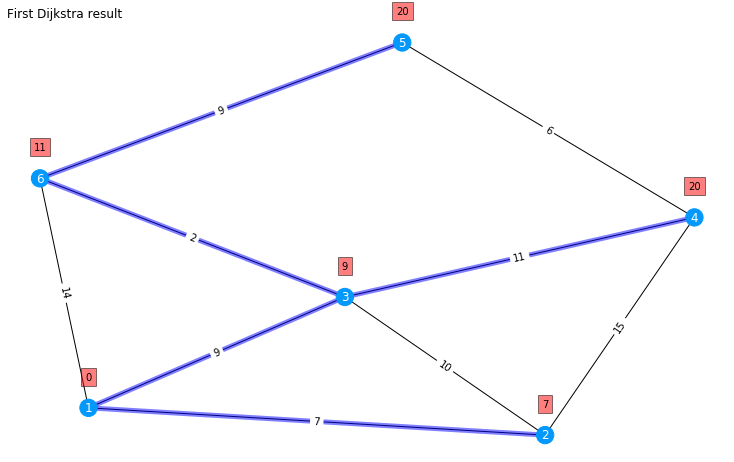

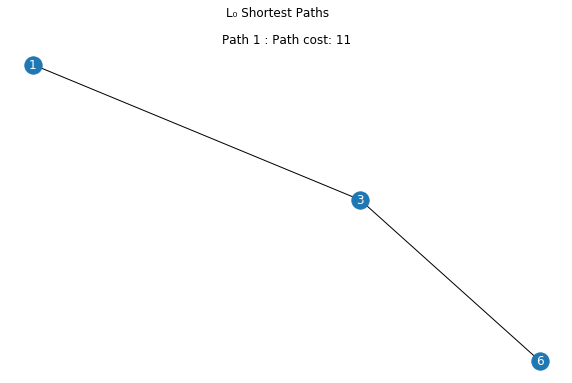

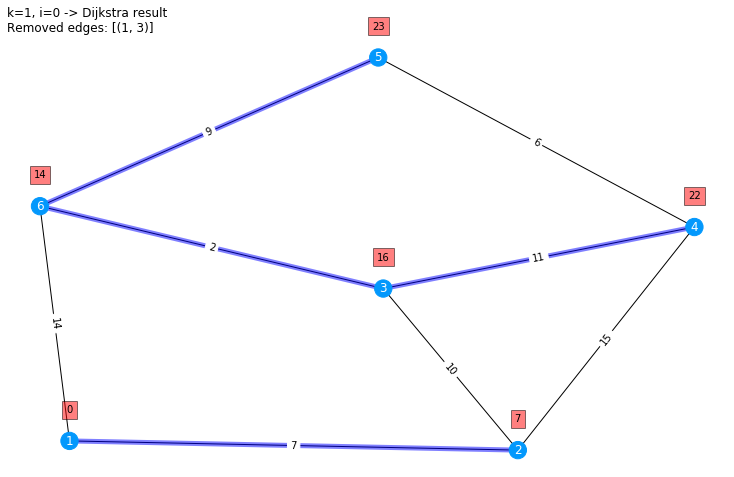

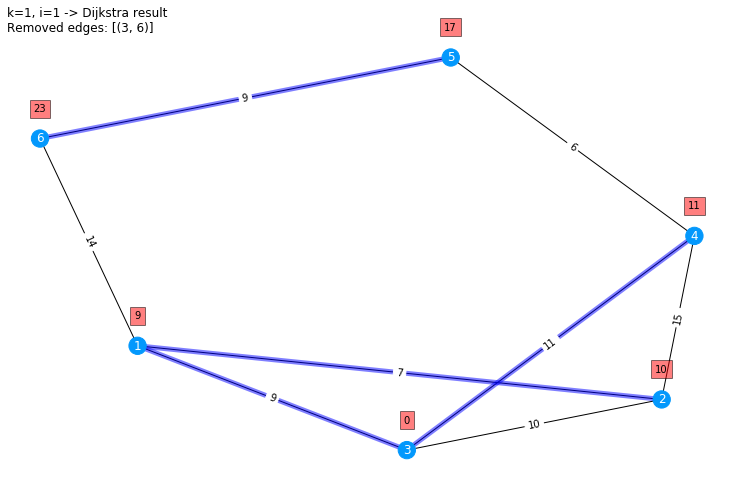

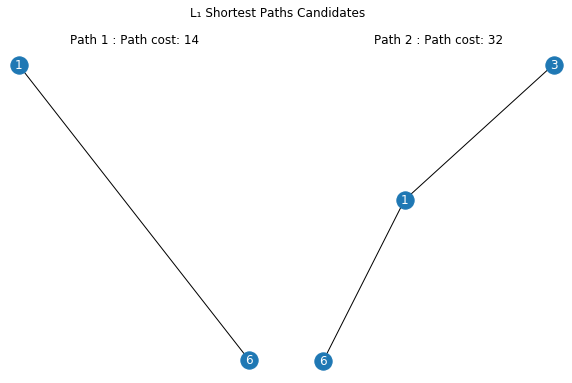

Shortest path added to L₀: {'cost': 14, 'path': [1, 6]}


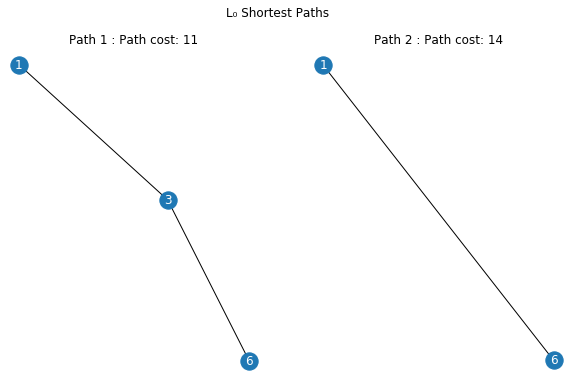

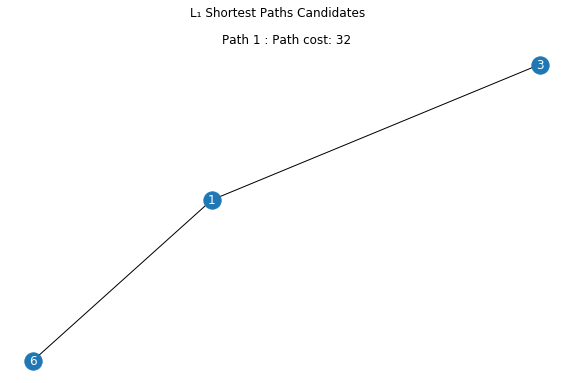

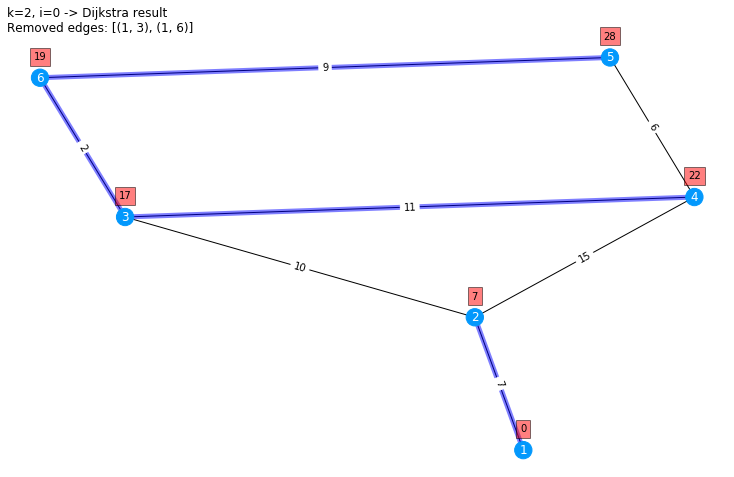

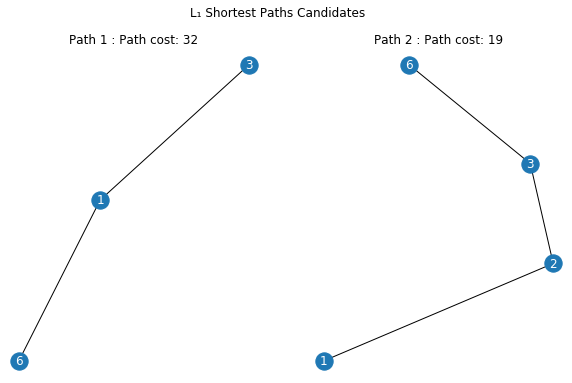

Shortest path added to L₀: {'cost': 19, 'path': [1, 2, 3, 6]}


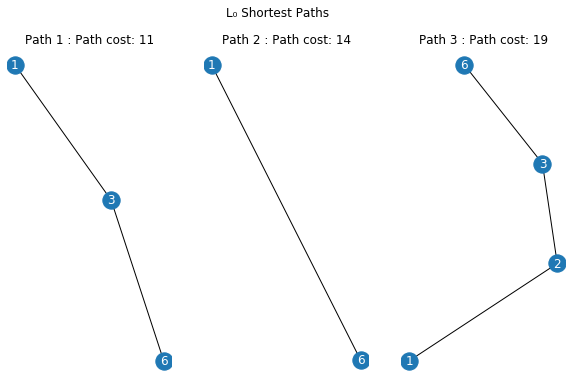

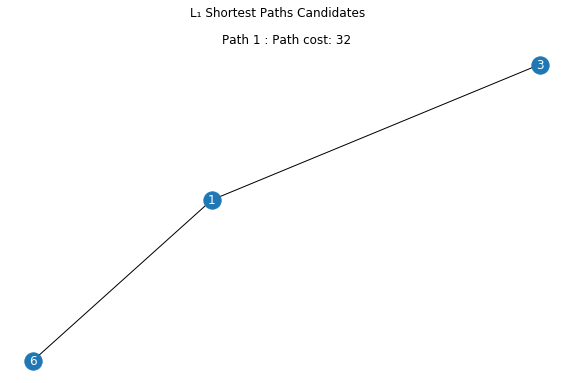

Found 3 paths: [{'cost': 11, 'path': [1, 3, 6]}, {'cost': 14, 'path': [1, 6]}, {'cost': 19, 'path': [1, 2, 3, 6]}]


In [0]:
k = 3
start = 1
end = 6
paths = ksp_yen(G, start, end, k)
print(f'Found {k} paths: {paths}')